In [8]:
from __future__ import print_function

# ignore warning of float precision
import warnings
warnings.filterwarnings('ignore')

import scipy

import matplotlib.pyplot as plt
import numpy as np
from random import random

from skimage import transform as tf
import math

import skimage
from skimage import io
from skimage.morphology import disk

def show(img, figsize=(10,10)):
    """
    Função para plotar uma imagem qualquer
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.show()

def green_to_transparency(img_in):
    """
    Adiciona transparência em cores verdes
    Parâmetros retirados no link
    http://marvinproject.sourceforge.net/en/examples/chromaKey.html
    """
    img = add_alpha_channel(img_in)
    hsv = skimage.color.rgb2hsv(img[:,:,:-1])

    width, height = img.shape[:-1]
    
    # In this step all pixels are processed in the HSV color space. Green pixels are converted
    # to transparent. Given a pixel p, it's is considered "green" if: 
    # p.hue >= 60 AND p.hue <= 130 AND p.saturation >= 0.4 AND p.lightness >= 0.3
    hue = hsv[:,:,0]
    saturation = hsv[:,:,1]
    lightness = hsv[:,:,2]
    for x in range(width):
        for y in range(height):
            if 0.25 <= hue[x][y] <= 0.5 and saturation[x][y] >= 0.4 and lightness[x][y] >= 0.3:
                img[x][y] = [0, 0, 0, 0]
    return img

def alpha_boundary(img, radius=3, sigma=3):
    """
    Efetua uma erosão nas bordas do canal alpha e aplica um filtro gaussiano
    """
    width, height = img.shape[:-1]
    alpha_filter = img[:,:,3]
    alpha_filter = erosion(alpha_filter, disk(radius))
    alpha_filter = skimage.filters.gaussian(alpha_filter, sigma=sigma, mode='constant', cval=0.0)
    img[:,:,3] = skimage.img_as_ubyte(alpha_filter)
    return img

def add_alpha_channel(img):
    """
    Adiciona um canal alpha a imagem
    RGB -> RGBA
    """
    rgba = np.concatenate((skimage.img_as_float(img[:,:,:3]), np.zeros((img.shape[0], img.shape[1], 1))), axis=2)
    rgba[:,:,3] = 1.0
    return skimage.img_as_ubyte(rgba)

def resize_image(img, scale):
    """
    Redimensiona scale% da imagem
    """
    return skimage.transform.resize(img, (int(img.shape[0]*scale/100), int(img.shape[1]*scale/100)), mode='reflect')

def open_image(name_file):
    """
    Abre a imagem em modo RGBA
    """
    return scipy.ndimage.imread(name_file, mode='RGBA')


In [9]:
def insert_image(background, image, position=None):
    """
    Insere a imagem no background
    position indica onde deve ser inserido (x, y),
    se não for passado é inserido aleatóriamente
    """
    if image.shape[0] > background.shape[0] or image.shape[1] > background.shape[1]:
        print('Image to insert is too bit to background')
        return
    
    # convert float to ubyte = uint8
    if str(image.dtype) == 'float64':
        image = skimage.img_as_ubyte(image)
    if str(background.dtype) == 'float64':
        background = skimage.img_as_ubyte(background)
    
    if position is None:
        position = int(random() * (background.shape[0]-image.shape[0])), \
            int(random() * (background.shape[1]-image.shape[1]))
    width, height = image.shape[:2]
    for x in range(width):
        for y in range(height):
            if image[x][y][3] != 0:
                
                value = np.multiply(image[x][y][3]/255, image[x][y][:3]) + \
                    np.multiply(1.0 - image[x][y][3]/255, background[position[0] + x][position[1] + y][:3])
                value = np.divide(value, 255)
                background[position[0] + x][position[1] + y][:3] = skimage.img_as_ubyte(value)

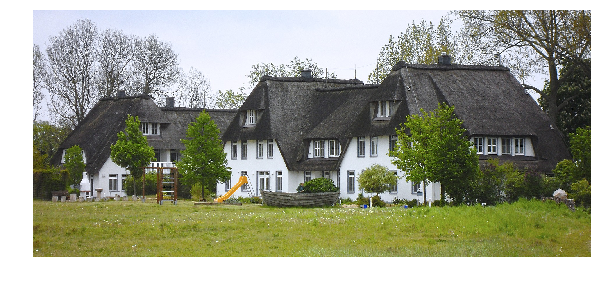

(849, 1920, 4)
(540, 960, 4)


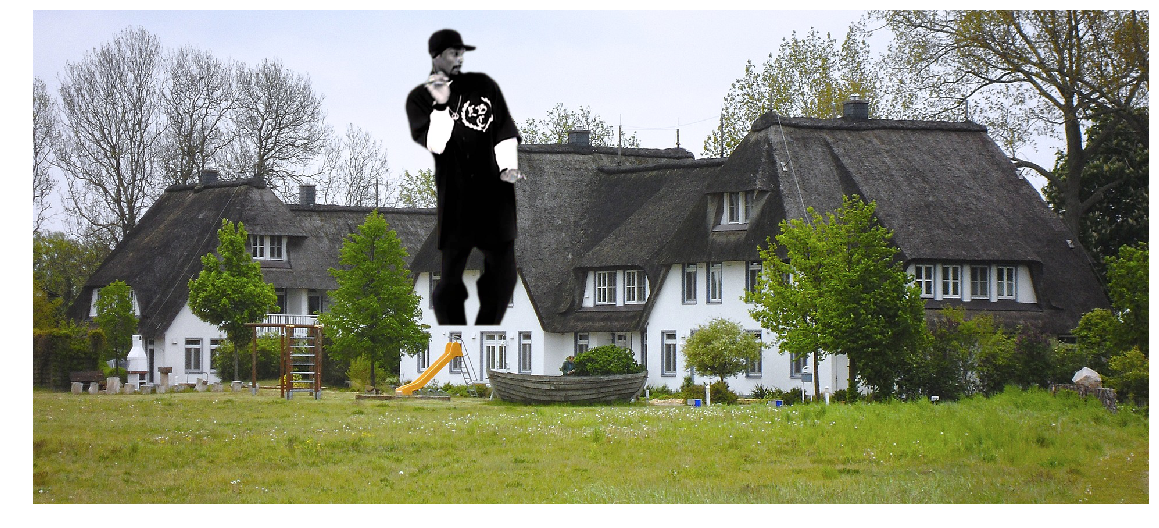

In [14]:
def test(name):
    img = open_image(name)
    background = open_image('img/background.jpg')
    show(background)
    img = green_to_transparency(img)
    alpha_boundary(img)
    img = resize_image(img, 50)
    insert_image(background, img)
    show(background, (20, 20))

    # show(filtered_img)
test('img/snoopydog.jpg')
# test('img/chairman.jpg')